In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pickle
import seg_metrics.seg_metrics as sg
import json
import SimpleITK as sitk
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from os.path import expanduser

#### compare the prediction from nnU-Net with the PET ground truth

In [2]:
DATASET_ID = 160
TEST_ID = 0
MODEL_CONFIG_SUFFIX = '' # '' or '/2d' i.e. none means 3d_fullres

In [3]:
RAW_DIR = '/mnt/data/datasets/RNSH_HFlung/nnU-Net-processing/nnUNet_raw'
DATASET_BASE_DIR = '{}/Dataset{}_RNSH_HFlung'.format(RAW_DIR, DATASET_ID)

In [4]:
CHECKPOINT = 'best'
# CHECKPOINT = 'final'

prediction_img = nib.load('/mnt/data/datasets/RNSH_HFlung/nnU-Net-processing/nnUNet_predictions/Dataset{}_RNSH_HFlung/{}{}/RNSH_HFlung_{:04d}.nii.gz'.format(DATASET_ID, CHECKPOINT, MODEL_CONFIG_SUFFIX, TEST_ID)).get_fdata().astype(int)
prediction_img.shape

/home/daryl/miniconda3/envs/py310/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


(320, 320, 300)

In [5]:
np.unique(prediction_img)

array([0, 1, 2, 3])

In [6]:
label_img = nib.load('{}/labelsTs/RNSH_HFlung_{:04d}.nii.gz'.format(DATASET_BASE_DIR, TEST_ID)).get_fdata().astype(int)
label_img.shape

(320, 320, 300)

In [7]:
DISPLAY_IDX = 150

In [8]:
labels_d = {0:'background', 1:'high', 2:'medium', 3:'low'}

# set up the colour map
colours_d = {
    0: 'black',
    1: 'lime',
    2: 'lightseagreen',
    3: 'slategray'
}

cm = ListedColormap(colours_d.values())

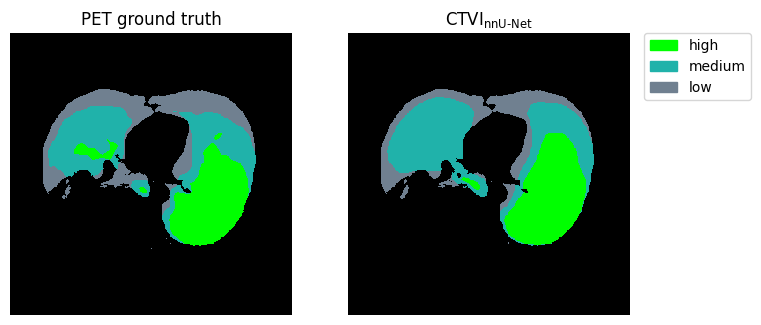

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

_ = ax1.imshow(label_img[:,:,DISPLAY_IDX].T, cmap=cm, interpolation='none')
ax1.set_title('PET ground truth')
ax1.set_axis_off()

im = ax2.imshow(prediction_img[:,:,DISPLAY_IDX].T, cmap=cm, interpolation='none')

# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colours_d[i], label="{l}".format(l=labels_d[i]) ) for i in [1,2,3] ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

if MODEL_CONFIG_SUFFIX == '':
    ax2.set_title(r'CTVI$_\text{nnU-Net}$')
else:
    ax2.set_title(r'CTVI$_\text{nnU-Net-2D}$')
ax2.set_axis_off()

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [11]:
nnunet_cm = confusion_matrix(label_img.ravel(), prediction_img.ravel(), labels=[1,2,3])
nnunet_cm = np.around(nnunet_cm.astype('float') / nnunet_cm.sum(axis=1)[:, np.newaxis], decimals=2)

In [12]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# base_color = '#4D5249'
base_color = '#20B2AA'
color_shades = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f']
cmap_colors = []

for color_shade in color_shades:
    cmap_colors.append(base_color+color_shade+color_shade)

confusion_matrix_cmap= ListedColormap(cmap_colors)

In [13]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 4,4

saved figure to /home/daryl/figures/confusion-matrix-ctvi-nnunet-dataset-160-test-00.svg


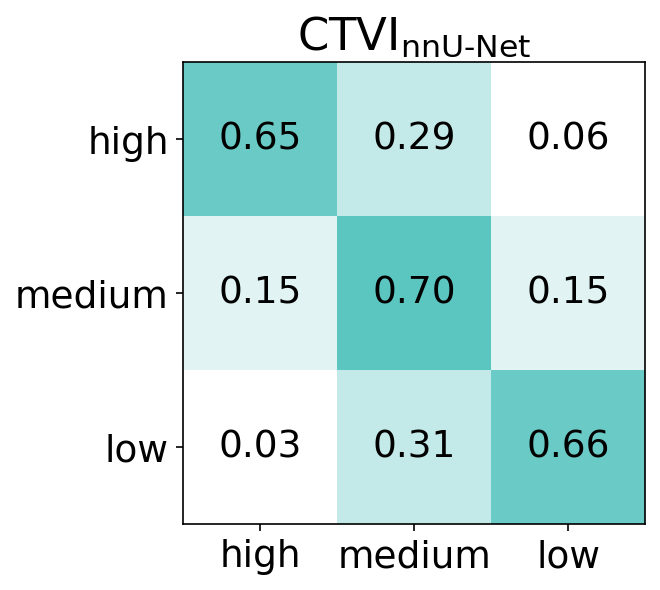

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=nnunet_cm, display_labels=['high','medium','low'])
disp.plot(values_format='.2f', cmap=confusion_matrix_cmap, 
          im_kw={'vmin':0, 'vmax':1.0}, 
          colorbar=False, 
          text_kw={'color':'black', 'fontsize':'medium', 'fontweight':'medium'})
if MODEL_CONFIG_SUFFIX == '':
    plt.title(r'CTVI$_\text{nnU-Net}$')
else:
    plt.title(r'CTVI$_\text{nnU-Net-2D}$')
plt.gca().xaxis.label.set_visible(False)
plt.gca().yaxis.label.set_visible(False)
fig_filename = '{}/figures/confusion-matrix-ctvi-nnunet{}-dataset-{:03d}-test-{:02d}.svg'.format(expanduser('~'), MODEL_CONFIG_SUFFIX.replace('/','-'), DATASET_ID, TEST_ID)
plt.savefig(fig_filename, format='svg', dpi=600, bbox_inches='tight')
print('saved figure to {}'.format(fig_filename))

In [15]:
nnunet_dsc = {}
print('nnU-Net and PET DSC')
for idx,label in enumerate(['high','medium','low']):
    k = idx+1
    dice = np.sum(prediction_img[label_img==k]==k)*2.0 / (np.sum(prediction_img[prediction_img==k]==k) + np.sum(label_img[label_img==k]==k))
    nnunet_dsc[label] = dice
    print('{}: {}'.format(label, round(dice,2)))

nnU-Net and PET DSC
high: 0.7
medium: 0.65
low: 0.68


In [16]:
labels = [1, 2, 3]  # high, medium, low

nnunet_metrics = sg.write_metrics(labels=labels,
                  gdth_img=label_img,
                  pred_img=prediction_img,
                  csv_file=None,
                  metrics=['vs','hd','hd95'])

nnunet_hd95 = {}
nnunet_hd95['high'] = nnunet_metrics[0]['hd95'][0]
nnunet_hd95['medium'] = nnunet_metrics[0]['hd95'][1]
nnunet_hd95['low'] = nnunet_metrics[0]['hd95'][2]

In [17]:
print('Hausdorff distance 95% percentile')
print('high: {}'.format(round(nnunet_hd95['high'])))
print('medium: {}'.format(round(nnunet_hd95['medium'])))
print('low: {}'.format(round(nnunet_hd95['low'])))

Hausdorff distance 95% percentile
high: 47
medium: 17
low: 10


#### compare with DIR approach

In [18]:
# get the patient ID for this hold-out test patient
MAPPING_FILE = '{}/patient-mapping-Dataset{}_RNSH_HFlung.json'.format(RAW_DIR, DATASET_ID)

with open(MAPPING_FILE, 'r') as fp:
    patient_map_d = json.load(fp)

In [19]:
patient_id = int(patient_map_d['test'][TEST_ID][0].split('/')[-1].split('.')[0].split('Patient')[1])
patient_id

4

In [20]:
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch'
PREPROCESSED_MHA_DIR = '{}/mha/Patient{:02d}'.format(PREPROCESSED_BASE_DIR, patient_id)

In [21]:
ctvi_jac_label_arr = sitk.GetArrayFromImage(sitk.ReadImage('{}/ctvi-jac-label.mha'.format(PREPROCESSED_MHA_DIR))).astype(int)
ctvi_jac_label_arr.shape

(300, 320, 320)

In [22]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 4,4

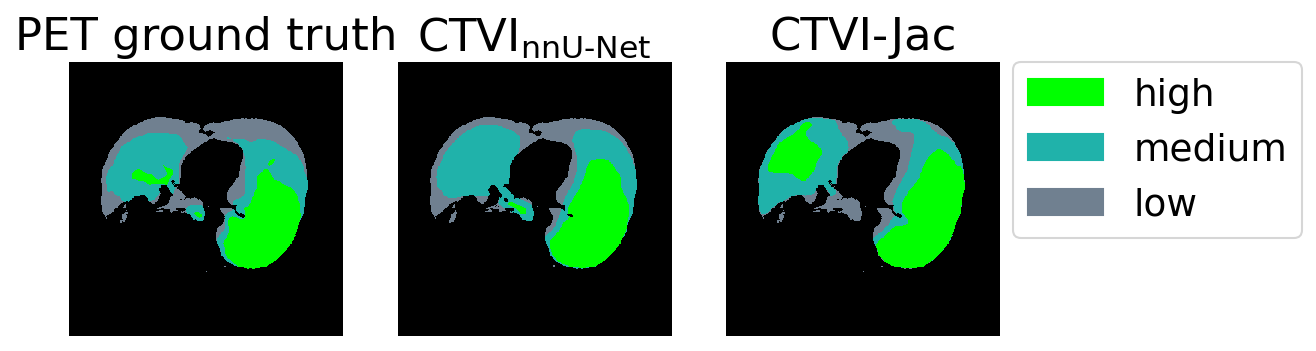

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,4))

ax1.imshow(label_img[:,:,DISPLAY_IDX].T, cmap=cm, interpolation='none')
ax1.set_title('PET ground truth')
ax1.set_axis_off()

ax2.imshow(prediction_img[:,:,DISPLAY_IDX].T, cmap=cm, interpolation='none')

if MODEL_CONFIG_SUFFIX == '':
    ax2.set_title(r'CTVI$_\text{nnU-Net}$')
else:
    ax2.set_title(r'CTVI$_\text{nnU-Net-2D}$')
ax2.set_axis_off()

ax3.imshow(ctvi_jac_label_arr[DISPLAY_IDX], cmap=cm, interpolation='none')

ax3.set_title('CTVI-Jac')
ax3.set_axis_off()

# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colours_d[i], label="{l}".format(l=labels_d[i]) ) for i in [1,2,3] ]
_ = plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

In [24]:
ctvi_jac_label_arr.shape, label_img.shape

((300, 320, 320), (320, 320, 300))

In [25]:
ctvi_jac_label_arr = np.transpose(ctvi_jac_label_arr, axes=(2, 1, 0))

In [26]:
ctvi_jac_cm = confusion_matrix(label_img.ravel(), ctvi_jac_label_arr.ravel(), labels=[1,2,3])
ctvi_jac_cm = np.around(ctvi_jac_cm.astype('float') / ctvi_jac_cm.sum(axis=1)[:, np.newaxis], decimals=2)

In [27]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 4,4

saved figure to /home/daryl/figures/confusion-matrix-ctvi-jac-dataset-160-test-00.svg


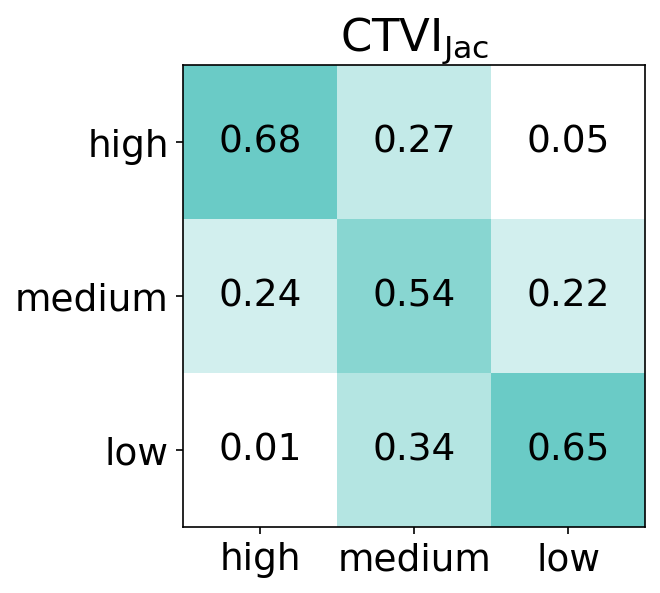

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=ctvi_jac_cm, display_labels=['high','medium','low'])
disp.plot(values_format='.2f', cmap=confusion_matrix_cmap, 
          im_kw={'vmin':0, 'vmax':1.0}, 
          colorbar=False, 
          text_kw={'color':'black', 'fontsize':'medium', 'fontweight':'medium'})
plt.title(r'CTVI$_\text{Jac}$')
plt.gca().xaxis.label.set_visible(False)
plt.gca().yaxis.label.set_visible(False)
fig_filename = '{}/figures/confusion-matrix-ctvi-jac-dataset-{:03d}-test-{:02d}.svg'.format(expanduser('~'), DATASET_ID, TEST_ID)
plt.savefig(fig_filename, format='svg', dpi=600, bbox_inches='tight')
print('saved figure to {}'.format(fig_filename))

saved figure to /home/daryl/figures/confusion-matrix-colorbar.svg


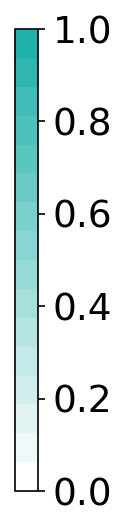

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=ctvi_jac_cm, display_labels=['high','medium','low'])
disp.plot(values_format='.2f', cmap=confusion_matrix_cmap, 
          im_kw={'vmin':0, 'vmax':1.0}, 
          colorbar=True, 
          text_kw={'color':'black', 'fontsize':'medium', 'fontweight':'medium'})
plt.title(r'CTVI$_\text{Jac}$')
plt.gca().xaxis.label.set_visible(False)
plt.gca().yaxis.label.set_visible(False)
plt.gca().set_visible(False)
fig_filename = '{}/figures/confusion-matrix-colorbar.svg'.format(expanduser('~'))
plt.savefig(fig_filename, format='svg', dpi=600, bbox_inches='tight')
print('saved figure to {}'.format(fig_filename))

In [30]:
ctvi_jac_dsc = {}
print('CTVI-Jac and PET DSC')
for idx,label in enumerate(['high','medium','low']):
    k = idx+1
    dice = np.sum(ctvi_jac_label_arr[label_img==k]==k)*2.0 / (np.sum(ctvi_jac_label_arr[ctvi_jac_label_arr==k]==k) + np.sum(label_img[label_img==k]==k))
    ctvi_jac_dsc[label] = dice
    print('{}: {}'.format(label, round(dice,2)))

CTVI-Jac and PET DSC
high: 0.68
medium: 0.54
low: 0.65


In [31]:
labels = [1, 2, 3]  # high, medium, low

jac_metrics = sg.write_metrics(labels=labels,
                  gdth_img=label_img,
                  pred_img=ctvi_jac_label_arr,
                  csv_file=None,
                  metrics=['vs','hd','hd95'])

ctvi_jac_hd95 = {}
ctvi_jac_hd95['high'] = jac_metrics[0]['hd95'][0]
ctvi_jac_hd95['medium'] = jac_metrics[0]['hd95'][1]
ctvi_jac_hd95['low'] = jac_metrics[0]['hd95'][2]

In [32]:
print('Hausdorff distance 95% percentile')
print('high: {}'.format(round(ctvi_jac_hd95['high'])))
print('medium: {}'.format(round(ctvi_jac_hd95['medium'])))
print('low: {}'.format(round(ctvi_jac_hd95['low'])))

Hausdorff distance 95% percentile
high: 26
medium: 15
low: 11


#### store the metrics by dataset and test patient ID

In [33]:
ANALYSIS_DIR = '/home/daryl/analysis{}'.format(MODEL_CONFIG_SUFFIX)
ANALYSIS_FILE = '{}/nnunet-metrics-final.pkl'.format(ANALYSIS_DIR)

In [34]:
if not os.path.exists(ANALYSIS_DIR):
    os.makedirs(ANALYSIS_DIR)

nnunet_d = {
    'confusion_matrix':nnunet_cm, 
    'DSC_low':np.round(nnunet_dsc['low'],2), 'DSC_medium':np.round(nnunet_dsc['medium'],2), 'DSC_high':np.round(nnunet_dsc['high'],2),
    'HD95_low':np.round(nnunet_hd95['low'],2), 'HD95_medium':np.round(nnunet_hd95['medium'],2), 'HD95_high':np.round(nnunet_hd95['high'],2),
}
ctvi_jac_d = {
    'confusion_matrix':ctvi_jac_cm, 
    'DSC_low':np.round(ctvi_jac_dsc['low'],2), 'DSC_medium':np.round(ctvi_jac_dsc['medium'],2), 'DSC_high':np.round(ctvi_jac_dsc['high'],2),
    'HD95_low':np.round(ctvi_jac_hd95['low'],2), 'HD95_medium':np.round(ctvi_jac_hd95['medium'],2), 'HD95_high':np.round(ctvi_jac_hd95['high'],2),
}
patient_d = {
    'dataset_id':DATASET_ID, 
    'test_id':TEST_ID, 
    'nnunet_d':nnunet_d,
    'ctvi_jac_d':ctvi_jac_d
}

print('updating analysis in {}'.format(ANALYSIS_FILE))

if os.path.isfile(ANALYSIS_FILE):
    with open(ANALYSIS_FILE, 'rb') as f:
        analysis_d = pickle.load(f)
else:
    analysis_d = {}

analysis_d[patient_id] = patient_d

with open(ANALYSIS_FILE, 'wb') as f:
    pickle.dump(analysis_d, f)

updating analysis in /home/daryl/analysis/nnunet-metrics-final.pkl


In [35]:
print('{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}'.format('patient ID', 'dataset', 'test ID', '', '', '', 'nnU-Net', '', '', '', 'CTVI-Jac'))
print('{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}'.format('', '', '', 'high', 'medium', 'low', 'mean', 'high', 'medium', 'low', 'mean'))
print('-'*110)

metadata_d = {'patient_id':[],'dataset_id':[],'test_id':[]}
ctvi_jac_DSC_d = {'high':[],'medium':[],'low':[],'mean':[]}
nnunet_DSC_d = {'high':[],'medium':[],'low':[],'mean':[]}
ctvi_jac_HD95_d = {'high':[],'medium':[],'low':[],'mean':[]}
nnunet_HD95_d = {'high':[],'medium':[],'low':[],'mean':[]}

df_l = []

for key,value in sorted(analysis_d.items()):
    # shorthand variables
    ctvi_jac_d = value['ctvi_jac_d']
    nnunet_d = value['nnunet_d']

    # metadata
    metadata_d['patient_id'].append(key)
    metadata_d['dataset_id'].append(value['dataset_id'])
    metadata_d['test_id'].append(value['test_id'])
    
    # DSC comparison
    ctvi_jac_DSC_d['high'].append(ctvi_jac_d['DSC_high'])
    ctvi_jac_DSC_d['medium'].append(ctvi_jac_d['DSC_medium'])
    ctvi_jac_DSC_d['low'].append(ctvi_jac_d['DSC_low'])
    ctvi_jac_DSC_mean = np.mean([ctvi_jac_d['DSC_high'],ctvi_jac_d['DSC_medium'],ctvi_jac_d['DSC_low']])
    ctvi_jac_DSC_d['mean'].append(ctvi_jac_DSC_mean)
    
    nnunet_DSC_d['high'].append(nnunet_d['DSC_high'])
    nnunet_DSC_d['medium'].append(nnunet_d['DSC_medium'])
    nnunet_DSC_d['low'].append(nnunet_d['DSC_low'])
    nnunet_DSC_mean = np.mean([nnunet_d['DSC_high'],nnunet_d['DSC_medium'],nnunet_d['DSC_low']])
    nnunet_DSC_d['mean'].append(nnunet_DSC_mean)
    
    # HD95 comparison
    ctvi_jac_HD95_d['high'].append(ctvi_jac_d['HD95_high'])
    ctvi_jac_HD95_d['medium'].append(ctvi_jac_d['HD95_medium'])
    ctvi_jac_HD95_d['low'].append(ctvi_jac_d['HD95_low'])
    ctvi_jac_HD95_mean = np.mean([ctvi_jac_d['HD95_high'],ctvi_jac_d['HD95_medium'],ctvi_jac_d['HD95_low']])
    ctvi_jac_HD95_d['mean'].append(ctvi_jac_HD95_mean)
    
    nnunet_HD95_d['high'].append(nnunet_d['HD95_high'])
    nnunet_HD95_d['medium'].append(nnunet_d['HD95_medium'])
    nnunet_HD95_d['low'].append(nnunet_d['HD95_low'])
    nnunet_HD95_mean = np.mean([nnunet_d['HD95_high'],nnunet_d['HD95_medium'],nnunet_d['HD95_low']])
    nnunet_HD95_d['mean'].append(nnunet_HD95_mean)
    
    print('{: >10}{: >10}{: >10}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}'.format(key, value['dataset_id'], value['test_id'], 
                                                                                 nnunet_d['DSC_high'], nnunet_d['DSC_medium'], nnunet_d['DSC_low'], nnunet_DSC_mean,
                                                                                 ctvi_jac_d['DSC_high'], ctvi_jac_d['DSC_medium'], ctvi_jac_d['DSC_low'], ctvi_jac_DSC_mean
                                                                                )
         )
print('-'*110)
print('{: >10}{: >10}{: >10}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}'.format('means', '', '', 
                                                                             np.mean(nnunet_DSC_d['high']), np.mean(nnunet_DSC_d['medium']), np.mean(nnunet_DSC_d['low']), np.mean(nnunet_DSC_d['mean']),
                                                                             np.mean(ctvi_jac_DSC_d['high']), np.mean(ctvi_jac_DSC_d['medium']), np.mean(ctvi_jac_DSC_d['low']), np.mean(ctvi_jac_DSC_d['mean'])
                                                                            )
     )

patient ID   dataset   test ID                                 nnU-Net                                CTVI-Jac
                                    high    medium       low      mean      high    medium       low      mean
--------------------------------------------------------------------------------------------------------------
         2       161         1      0.55      0.56      0.60      0.57      0.39      0.47      0.56      0.47
         4       160         0      0.70      0.65      0.68      0.68      0.68      0.54      0.65      0.62
         7       162         1      0.72      0.58      0.55      0.62      0.66      0.56      0.71      0.64
         9       160         1      0.72      0.67      0.66      0.68      0.65      0.59      0.62      0.62
        11       161         0      0.75      0.70      0.75      0.73      0.72      0.65      0.73      0.70
        14       162         0      0.81      0.77      0.85      0.81      0.67      0.58      0.74      0.66
-

#### box plot for DSC

In [36]:
boxplot_nnunet = []
boxplot_nnunet.append(nnunet_DSC_d['high'])
boxplot_nnunet.append(nnunet_DSC_d['medium'])
boxplot_nnunet.append(nnunet_DSC_d['low'])

boxplot_dir = []
boxplot_dir.append(ctvi_jac_DSC_d['high'])
boxplot_dir.append(ctvi_jac_DSC_d['medium'])
boxplot_dir.append(ctvi_jac_DSC_d['low'])

In [37]:
print('high-function DSC mean (range)')
print('nnU-Net{} = {:0.2f} ({:0.2f} to {:0.2f})'.format(MODEL_CONFIG_SUFFIX.replace('/','-'), np.mean(boxplot_nnunet[0]), np.min(boxplot_nnunet[0]), np.max(boxplot_nnunet[0])))
print('Jac = {:0.2f} ({:0.2f} to {:0.2f})'.format(np.mean(boxplot_dir[0]), np.min(boxplot_dir[0]), np.max(boxplot_dir[0])))

high-function DSC mean (range)
nnU-Net = 0.71 (0.55 to 0.81)
Jac = 0.63 (0.39 to 0.72)


In [38]:
import pandas as pd
rows_l = []
for patient_id in analysis_d.keys():
    patient_d = analysis_d[patient_id]
    for model in ['nnunet','ctvi_jac']:
        for metric in ['DSC','HD95']:
            for subregion in ['high','medium','low']:
                d = {'patient_id':patient_id, 'dataset_id':patient_d['dataset_id'], 'test_id':patient_d['test_id']}
                d['model'] = model
                d['metric'] = metric
                d['subregion'] = subregion
                d['value'] = patient_d[model+'_d'][metric+'_'+subregion]
                rows_l.append(d)
analysis_df = pd.DataFrame(rows_l)

In [39]:
analysis_df.head()

,patient_id,dataset_id,test_id,model,metric,subregion,value
0,4,160,0,nnunet,DSC,high,0.70
1,4,160,0,nnunet,DSC,medium,0.65
2,4,160,0,nnunet,DSC,low,0.68
3,4,160,0,nnunet,HD95,high,47.46
4,4,160,0,nnunet,HD95,medium,16.55


In [40]:
def box_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    mask = (series < Q1 - 1.5 * IQR) | (series > Q3 + 1.5 * IQR)
    series = series[mask]
    return series

In [41]:
label_offsets = {'nnunet':-0.15, 'ctvi_jac':0.25}
plot_x = {'high':0, 'medium':1, 'low':2}

In [42]:
dsc_analysis_df = analysis_df[analysis_df['metric']=='DSC']

In [43]:
params = {}
params['font.size'] = 18
params['figure.dpi'] = 150
params['figure.figsize'] = 9,7

plt.rcParams.update(params)

saved figure to /home/daryl/figures/ctvi-nnunet-jac-DSC-boxplot.svg


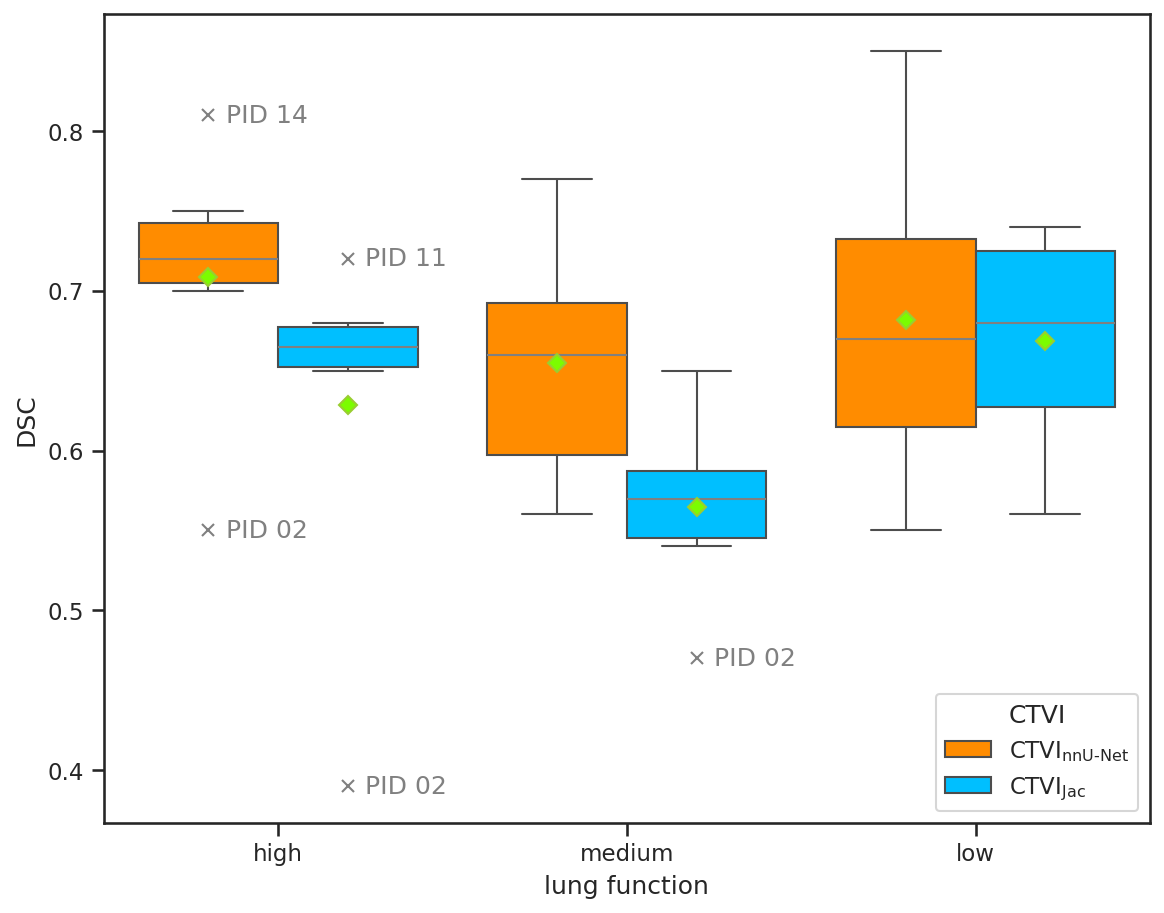

In [44]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

bp = sns.boxplot(x="subregion", y="value",
                 hue="model", palette=['darkorange','deepskyblue'], 
                 flierprops=dict(markerfacecolor='lightgrey', marker='x', markeredgecolor='grey'),
                 medianprops={"color": "gray", "linewidth": 1}, 
                 meanprops=dict(markerfacecolor='lawngreen', marker='D', markeredgecolor='yellowgreen'),
                 saturation=1.0, 
                 showmeans=True,
                 legend=True,
                 data=dsc_analysis_df)

# label the outliers
for model in label_offsets.keys():
    for subregion_idx,subregion in enumerate(['high','medium','low']):
        df = dsc_analysis_df[(dsc_analysis_df['model'] == model) & (dsc_analysis_df['subregion'] == subregion)]
        outliers = box_outliers(df.value)
        for o in outliers:
            patient_id = df.iloc[(df['value'] - o).abs().argsort()[:1]].patient_id.iloc[0]
            plt.text(plot_x[subregion]+label_offsets[model], o, 'PID {:02d}'.format(patient_id), ha='left', va='center', fontsize=12, color='grey')

# modify the legend
legend = bp.get_legend()
legend.set_title('CTVI')
if MODEL_CONFIG_SUFFIX == '':
    new_labels = [r'CTVI$_\text{nnU-Net}$', r'CTVI$_\text{Jac}$']
else:
    new_labels = [r'CTVI$_\text{nnU-Net-2D}$', r'CTVI$_\text{Jac}$']
for t, l in zip(legend.texts, new_labels):
    t.set_text(l)
legend.set_loc('lower right')

_ = bp.set_xlabel('lung function')
_ = bp.set_ylabel('DSC')

fig_filename = '{}/figures/ctvi-nnunet{}-jac-DSC-boxplot.svg'.format(expanduser('~'), MODEL_CONFIG_SUFFIX.replace('/','-'))
plt.savefig(fig_filename, format='svg', dpi=600, bbox_inches='tight')
print('saved figure to {}'.format(fig_filename))

#### box plot for HD95

In [45]:
boxplot_nnunet = []
boxplot_nnunet.append(nnunet_HD95_d['high'])
boxplot_nnunet.append(nnunet_HD95_d['medium'])
boxplot_nnunet.append(nnunet_HD95_d['low'])

boxplot_dir = []
boxplot_dir.append(ctvi_jac_HD95_d['high'])
boxplot_dir.append(ctvi_jac_HD95_d['medium'])
boxplot_dir.append(ctvi_jac_HD95_d['low'])

In [46]:
print('high-function HD95 mean (range)')
print('nnU-Net{} = {:0.2f} ({:0.2f} to {:0.2f})'.format(MODEL_CONFIG_SUFFIX.replace('/','-'), np.mean(boxplot_nnunet[0]), np.min(boxplot_nnunet[0]), np.max(boxplot_nnunet[0])))
print('Jac = {:0.2f} ({:0.2f} to {:0.2f})'.format(np.mean(boxplot_dir[0]), np.min(boxplot_dir[0]), np.max(boxplot_dir[0])))

high-function HD95 mean (range)
nnU-Net = 32.62 (15.07 to 47.46)
Jac = 33.40 (22.72 to 62.83)


In [47]:
hd95_analysis_df = analysis_df[analysis_df['metric']=='HD95']

In [48]:
params = {}
params['font.size'] = 18
params['figure.dpi'] = 150
params['figure.figsize'] = 9,7

plt.rcParams.update(params)

saved figure to /home/daryl/figures/ctvi-nnunet-jac-HD95-boxplot.svg


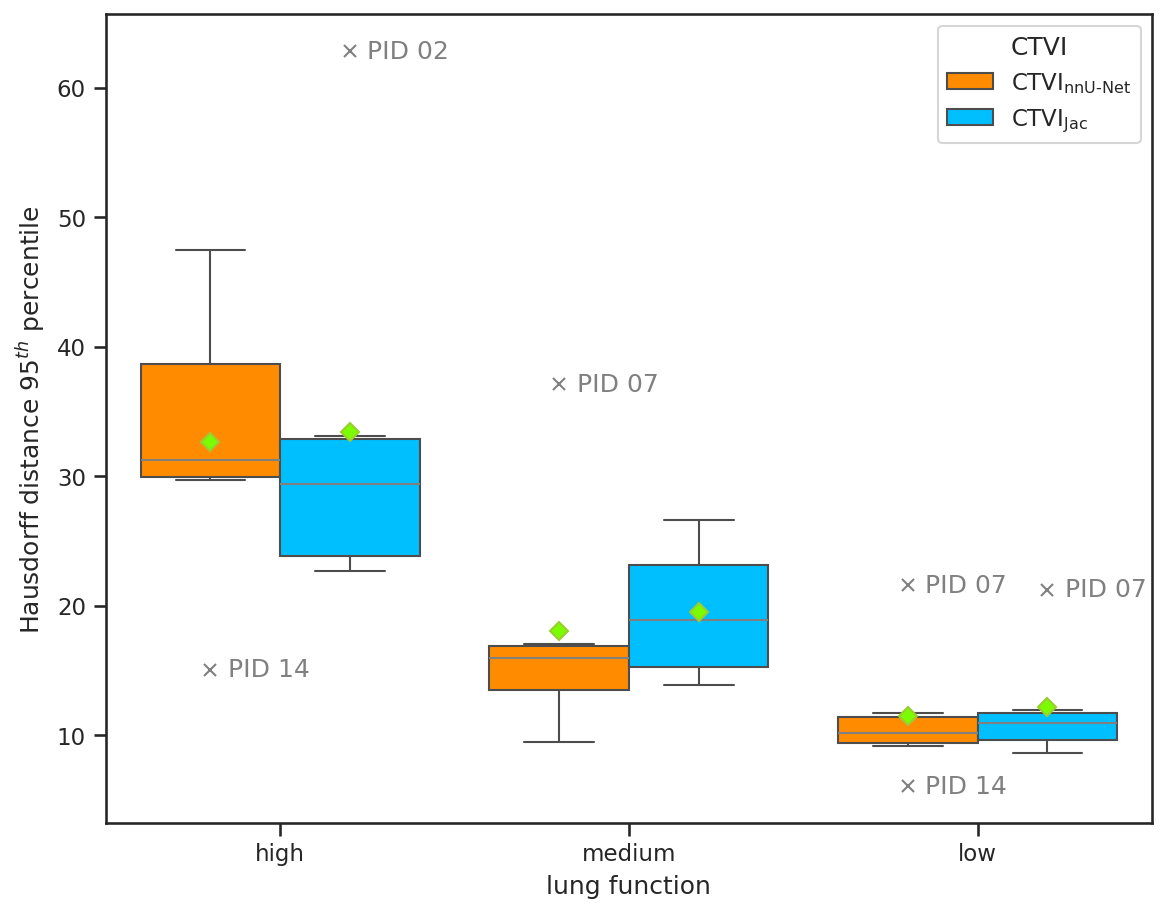

In [49]:
sns.set_theme(style="ticks", palette="pastel")

bp = sns.boxplot(x="subregion", y="value",
                 hue="model", palette=['darkorange','deepskyblue'], 
                 flierprops=dict(markerfacecolor='lightgrey', marker='x', markeredgecolor='grey'),
                 medianprops={"color": "gray", "linewidth": 1}, 
                 meanprops=dict(markerfacecolor='lawngreen', marker='D', markeredgecolor='yellowgreen'),
                 saturation=1.0, 
                 showmeans=True,
                 legend=True,
                 data=hd95_analysis_df)

# label the outliers
for model in label_offsets.keys():
    for subregion_idx,subregion in enumerate(['high','medium','low']):
        df = hd95_analysis_df[(hd95_analysis_df['model'] == model) & (hd95_analysis_df['subregion'] == subregion)]
        outliers = box_outliers(df.value)
        for o in outliers:
            patient_id = df.iloc[(df['value'] - o).abs().argsort()[:1]].patient_id.iloc[0]
            plt.text(plot_x[subregion]+label_offsets[model], o, 'PID {:02d}'.format(patient_id), ha='left', va='center', fontsize=12, color='grey')

# modify the legend
legend = bp.get_legend()
legend.set_title('CTVI')
if MODEL_CONFIG_SUFFIX == '':
    new_labels = [r'CTVI$_\text{nnU-Net}$', r'CTVI$_\text{Jac}$']
else:
    new_labels = [r'CTVI$_\text{nnU-Net-2D}$', r'CTVI$_\text{Jac}$']
for t, l in zip(legend.texts, new_labels):
    t.set_text(l)

_ = bp.set_xlabel('lung function')
_ = bp.set_ylabel('Hausdorff distance 95$^{th}$ percentile')

fig_filename = '{}/figures/ctvi-nnunet{}-jac-HD95-boxplot.svg'.format(expanduser('~'), MODEL_CONFIG_SUFFIX.replace('/','-'))
plt.savefig(fig_filename, format='svg', dpi=600, bbox_inches='tight')
print('saved figure to {}'.format(fig_filename))